# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import warnings


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


First, let's look at how many features and observations the datasets contain.

In [3]:
azdias.shape

(891221, 366)

In [4]:
customers.shape

(191652, 369)

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Then, I upload the datasets containing the additional information on the features I am going to use in the project. 

In [2]:
attributes = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header = 1)

In [3]:
values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header = 1)

In [9]:
attributes.shape

(313, 5)

In [27]:
attributes.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [12]:
len(np.intersect1d(azdias.columns, values['Attribute'].dropna()))

272

We can see that there are 272 features in the general population dataframe for which we have additional information. I  leave only these features in the both datasets I am working with.

In [13]:
common = np.intersect1d(np.intersect1d(azdias.columns, values['Attribute'].dropna()), customers.columns)
azdias = azdias[list(common)]
customers = customers[list(common)]

In [7]:
values.head(15)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,NaN,NaN,1,< 30 years
NaN,NaN,NaN,2,30 - 45 years
NaN,NaN,NaN,3,46 - 60 years
NaN,NaN,NaN,4,> 60 years


### Recoding NaNs

In the dataset 'values', there is information on how NaN values are coded for each feature. I need to recode them. For that, I have to restructure the dataset 'values' a bit. I am going to find all the codes that correspond to *unknown* or *non-detectable* values and group them on the base of each feature. 

In [4]:
# identifying all values having 'unknown' or 'non-detectable' meanings
values_na = values.fillna(method = 'pad')[values["Meaning"].str.contains('no\s|unknown', case=False, na=False)]
# grouping them based on the features
values_na['Value'] = values_na['Value'].apply(str)
values_na = values_na.groupby('Attribute')['Value'].apply(','.join).reset_index()

In [9]:
values_na.head(10)

,Attribute,Value
0,AGER_TYP,"-1,0"
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ALTER_HH,0
3,ANREDE_KZ,"-1, 0"
4,BALLRAUM,-1
5,BIP_FLAG,"-1,0"
6,CAMEO_DEUG_2015,-1
7,CAMEO_DEUINTL_2015,-1
8,CJT_GESAMTTYP,0
9,D19_BANKEN_ANZ_12,0


In [6]:
# writing two functions that would help to identify NaN values for each feature and to recode them

def identify_nans(column, df):
    """
    The function identifies NaNs based on the dataset 'vales'

    Arguments:
        column: Pandas series 
        df: Pandas DataFrame

    Returns:
        Pandas series with recoded NaNs
    """
    
    nans = values_na[values_na['Attribute'] == column]['Value'].str.split(',')
    nans = [int(i) for x in nans for i in x]
    found_nans = df[column].apply(lambda x: np.nan if np.in1d(x, nans) else x)
    
    return found_nans

def replace_unknowns(df):
    """
    The function applies 'identify_nans' for all columns in a dataset

    Arguments:
        df: Pandas DataFrame

    Returns:
        Pandas DataFrame with recoded values for all columns
    """
    df_copy = df.copy()
    for column in tqdm(df.columns):
        df_copy[column] = identify_nans(column, df)
    
    return df_copy

In [ ]:
azdias_cleaned = replace_unknowns(azdias)

In [ ]:
# recoding took some time, so it would be a good idea to save the recoded dataframes
azdias_cleaned.to_csv('azdias_cleaned.csv')

In [ ]:
customers_cleaned = replace_unknowns(customers)

In [ ]:
customers_cleaned.to_csv('customers_cleaned.csv')

In [2]:
azdias_cleaned = pd.read_csv('azdias_cleaned.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers_cleaned = pd.read_csv('customers_cleaned.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
customers_cleaned = customers_cleaned.drop(['Unnamed: 0'], axis = 1)
azdias_cleaned = azdias_cleaned.drop(['Unnamed: 0'], axis = 1)

### Removing columns and rows with many NaNs

In the next step, I need to remove those columns that have too many NaN values. For that, I need to look at the distribution of NaN values in the columns and define a threshold based on it. All columns that have a number of NaNs higher than this defined threshold will be removed.

(array([  37.,    4.,  137.,   59.,    0.,    1.,    1.,    2.,    1.,
           2.,    2.,    2.,    2.,    1.,    5.,    3.,    2.,    2.,
           4.,    5.]),
 array([ 0.        ,  0.04987882,  0.09975764,  0.14963645,  0.19951527,
         0.24939409,  0.29927291,  0.34915173,  0.39903054,  0.44890936,
         0.49878818,  0.548667  ,  0.59854582,  0.64842463,  0.69830345,
         0.74818227,  0.79806109,  0.8479399 ,  0.89781872,  0.94769754,
         0.99757636]),
 <a list of 20 Patch objects>)

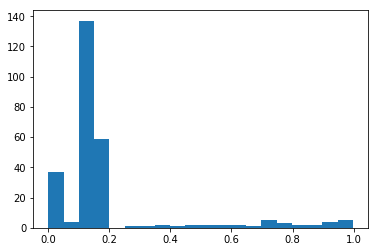

In [7]:
plt.hist((len(azdias_cleaned) - azdias_cleaned.count())/len(azdias_cleaned), bins = 20)

In [8]:
((len(azdias_cleaned) - azdias_cleaned.count())/len(azdias_cleaned) <= 0.2).value_counts()

True     237
False     35
dtype: int64

We can observe that the majority of columns in the general population dataset (n = 238) have less or equal to 2 percent of missing values. For further analysis, I will remove other columns (n = 35)

(array([  37.,    0.,    0.,    0.,    4.,  139.,   59.,    2.,    1.,
           3.,    6.,    2.,    1.,    0.,    2.,    1.,    1.,    3.,
           5.,    6.]),
 array([ 0.        ,  0.04944274,  0.09888548,  0.14832822,  0.19777096,
         0.2472137 ,  0.29665644,  0.34609918,  0.39554192,  0.44498466,
         0.4944274 ,  0.54387014,  0.59331288,  0.64275562,  0.69219836,
         0.7416411 ,  0.79108384,  0.84052658,  0.88996932,  0.93941206,
         0.9888548 ]),
 <a list of 20 Patch objects>)

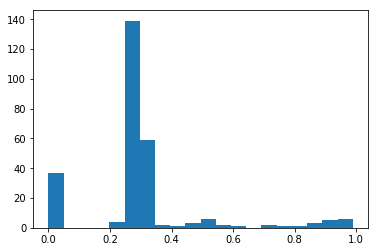

In [9]:
plt.hist((len(customers_cleaned) - customers_cleaned.count())/len(customers_cleaned), bins = 20)

In [10]:
((len(customers_cleaned) - customers_cleaned.count())/len(customers_cleaned) <= 0.3).value_counts()

True     236
False     36
dtype: int64

The distribution of NaN values in the dataset with customers' information is a bit different, so I will define a bit higher threshold for it; all the columns having more than 3 percent of missing values.

In [11]:
remove_customers = customers_cleaned.columns[(len(customers_cleaned) - customers_cleaned.count())/
                                             len(customers_cleaned) > 0.3]

In [12]:
remove_azdias = azdias_cleaned.columns[(len(azdias_cleaned) - azdias_cleaned.count())/
                                             len(azdias_cleaned) > 0.2]

In [13]:
np.setdiff1d(remove_customers, remove_azdias)

array(['KKK', 'REGIOTYP'], dtype=object)

In [14]:
np.setdiff1d(remove_azdias, remove_customers)

array(['D19_KONSUMTYP'], dtype=object)

Based on the previous lines of code, we can see that the columns we are going to remove from both datasets are very similar (only three columns do not match). 

In [5]:
stay_customers = customers_cleaned.columns[(len(customers_cleaned) - customers_cleaned.count())/
                                             len(customers_cleaned) <= 0.3]

In [6]:
stay_azdias = azdias_cleaned.columns[(len(azdias_cleaned) - azdias_cleaned.count())/
                                             len(azdias_cleaned) <= 0.2]

In [7]:
common = np.intersect1d(stay_customers, stay_azdias)

In [8]:
customers_cleaned = customers_cleaned[common]

In [9]:
azdias_cleaned = azdias_cleaned[common]

The similar distributions of missing values were constructed for rows of the datasets.

(array([  7.19538000e+05,   1.71810000e+04,   5.13000000e+02,
          5.50000000e+01,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.56700000e+03,   3.49570000e+04,
          8.56900000e+03,   9.37000000e+02,   1.00000000e+02,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.08000000e+02,
          1.44000000e+02,   4.84200000e+03,   3.11000000e+02,
          1.70000000e+01,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   5.00000000e+00,   1.72000000e+02,
          5.43400000e+03,   1.13400000e+03,   6.90000000e+01,
          3.65600000e+03,   1.54460000e+04,   7.39820000e+04,
          7.90000000e+01]),
 array([   0.   ,    5.125,   10.25 ,   15.375,   20.5  ,   25.625,
          30.75 ,   35.875,   41.   ,   46.125,   51.25 ,   56.375,
          61.5  ,   66.625,   

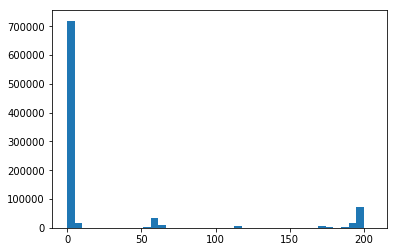

In [20]:
plt.hist(azdias_cleaned.isnull().sum(axis=1), bins=40)

(array([  1.30650000e+05,   3.45600000e+03,   1.28000000e+02,
          1.10000000e+01,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.77000000e+02,   4.70100000e+03,
          1.08500000e+03,   1.46000000e+02,   1.60000000e+01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.50000000e+01,
          9.00000000e+00,   4.17000000e+02,   2.20000000e+01,
          1.00000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+01,
          5.48000000e+02,   2.89000000e+02,   8.00000000e+00,
          5.00000000e+01,   3.16000000e+03,   4.66320000e+04,
          8.90000000e+01]),
 array([   0. ,    5.1,   10.2,   15.3,   20.4,   25.5,   30.6,   35.7,
          40.8,   45.9,   51. ,   56.1,   61.2,   66.3,   71.4,   76.5,
          81.6,   86.7

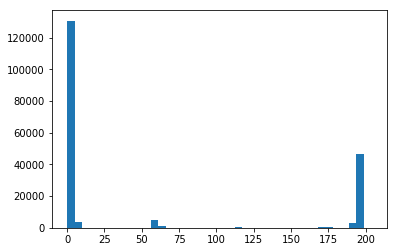

In [21]:
plt.hist(customers_cleaned.isnull().sum(axis=1), bins=40)

In [20]:
len(customers_cleaned.isnull().sum(axis = 1)[customers_cleaned.isnull().sum(axis = 1) > 50])/customers_cleaned.shape[0]

0.29953248596414334

In [11]:
len(azdias_cleaned.isnull().sum(axis = 1)[azdias_cleaned.isnull().sum(axis = 1) > 50])/azdias_cleaned.shape[0]

0.17272146863684765

If we take 50 missing values as a threshold, we can observe that numbers of rows we should remove from the datasets are different. In the dataset with customers' information, there are much more the rows having more than 50 missing values.

To decide if removing rows (based on the chosen threshold) is a nice idea, I divide each dataset into two groups: the first one contains only those rows that have less missing values than a defined threshold, and the second one contains other rows. Then, I compare how the distributions of values in some columns (those ones that do not have missing values) differ between these two groups. If the distributions are not very different, then I can freely drop those rows that exceed the threshold. In the opposite case, it would be dangerous to remove these rows as I am going to lose some important information from my data. 

In [13]:
def compare_dists(df, threshold, num_columns):
    """
    The function divides a dataset into two parts based on the chosen threholds and draws the distributions of values 
    for columns not having missing data (or having few missing values)

    Arguments:
        df: pandas DataFrame
        threshold: numeric value identifying the number of NaNs in a row
        num_columns: numeric value identifying the number of columns for which the function calculates distributions

    Returns:
        Charts showing distributions of values for two groups
    """
    
    print('dividing the dataset')
    
    df_indexes_more = df.isnull().sum(axis = 1)[df.isnull().sum(axis = 1) > threshold].index
    df_indexes_less = df.isnull().sum(axis = 1)[df.isnull().sum(axis = 1) <= threshold].index
    
    df_more = df.iloc[df_indexes_more,]
    df_less = df.iloc[df_indexes_less,]
    
    col_to_check = ((len(df) - df.count())/len(df)).sort_values(ascending = True).head(num_columns)
    
    print('drawing a chart')
    
    for i in col_to_check.index:
        fig, ax =plt.subplots(1,2)
        sns.countplot(df_less[i], ax=ax[0])
        sns.countplot(df_more[i], ax=ax[1])  
        plt.subplots_adjust(right = 1.5)
        fig.show()

dividing the dataset
drawing a chart


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


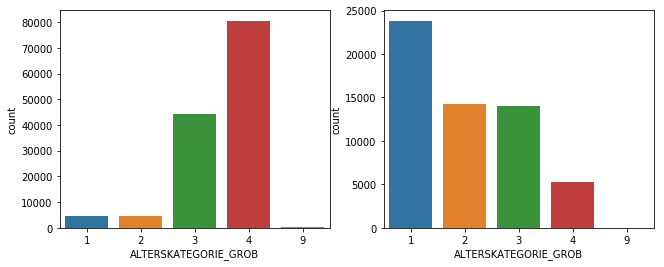

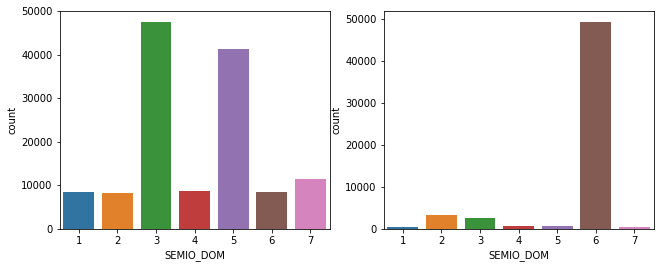

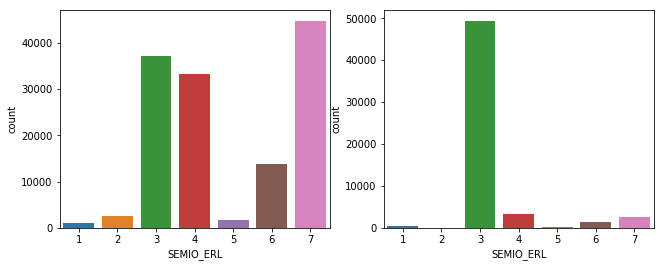

In [16]:
compare_dists(customers_cleaned, 50, 3)

dividing the dataset
drawing a chart


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


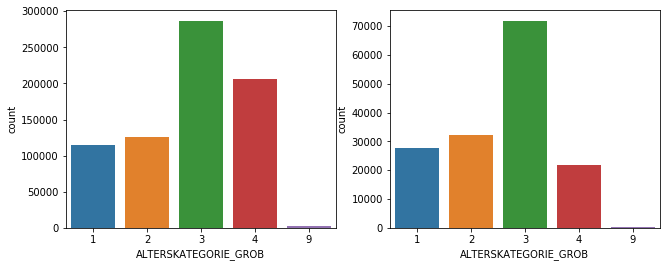

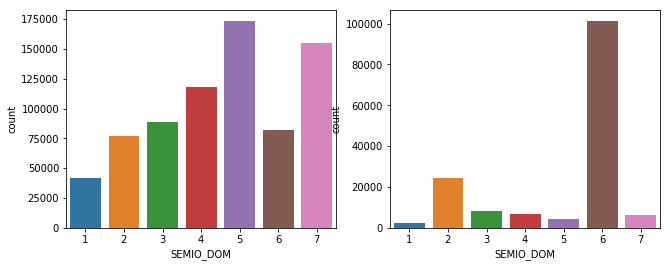

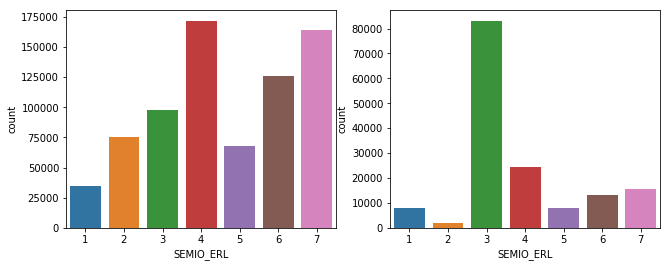

In [17]:
compare_dists(azdias_cleaned, 50, 3)

As we can see from the charts, the distributions of values in the groups are quite different, so it's dangerous to drop all these values (especially, in the customers' dataset where such rows make almost 30% of data). 

### Recoding variables

In the next step of data preparation, I need to recode some of the categorical variables that I have in the datasets.

In [26]:
customers_cleaned.dtypes.value_counts()

float64    206
int64       26
object       3
dtype: int64

I need to work on three variables that are categorical ones.

In [10]:
cat_variables = list(customers_cleaned.columns[customers_cleaned.dtypes == 'object'])

In [14]:
attributes[attributes['Attribute'].isin(cat_variables)]

,Unnamed: 0,Information level,Attribute,Description,Additional notes
83,NaN,NaN,OST_WEST_KZ,flag indicating the former GDR/FRG,NaN
85,NaN,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,New German CAMEO Typology established together...
86,NaN,NaN,CAMEO_DEU_2015,CAMEO_4.0: specific group,NaN


In [15]:
# to explore the values of these categorical variables, I need to restructure the dataset with values a bit
values_filled = values.fillna(method = 'pad')

In [16]:
values_filled[values_filled['Attribute'].isin(cat_variables)]

,Unnamed: 0,Attribute,Description,Value,Meaning
51,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


Based on the information from the values dataset, I already can see that I didn't recode all missing values in my data. In the variable *CAMEO_DEUG_2015*, some of the missing values are marked by *X*. I need to recode them. Some of the values in this variable are strings, and others are floats. I will recode all of them into floats.

In [11]:
customers_cleaned.loc[customers_cleaned['CAMEO_DEUG_2015'] == 'X', 'CAMEO_DEUG_2015'] = np.nan

In [12]:
customers_cleaned['CAMEO_DEUG_2015'] = customers_cleaned['CAMEO_DEUG_2015'].astype('float64')

The variable *CAMEO_DEU_2015* can be dropped as it represents the same information as *CAMEO_DEUG_2015* but in more granulated way.

In [13]:
customers_cleaned = customers_cleaned.drop('CAMEO_DEU_2015', axis = 1)

Another variable that should be recoded is called *OST_WEST_KZ*. It has only two variables, so I just create a dummy variable from it.

In [14]:
# creating a dummy variable, NaN values are saved as I wanna impute them later
west_ost = pd.get_dummies(customers_cleaned['OST_WEST_KZ'], dummy_na = True, drop_first = True)
west_ost.columns = ['W', 'nans']
west_ost.loc[west_ost['nans'] == 1, 'W'] = np.nan
west_ost = west_ost.drop('nans', axis = 1)

In [15]:
# dropping the original variable 
customers_cleaned = customers_cleaned.drop('OST_WEST_KZ', axis = 1)

In [16]:
# merging the dummy variable
customers_cleaned = pd.concat([customers_cleaned, west_ost], axis = 1)

I also decided to explore the variables having additional notes as I assumed some of them should be recoded as well.

In [94]:
attributes[(attributes['Additional notes'].notnull()) & 
           (attributes['Attribute'].isin(customers_cleaned.columns))]

,Unnamed: 0,Information level,Attribute,Description,Additional notes
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
13,NaN,NaN,GREEN_AVANTGARDE,the environmental sustainability is the domina...,own typology based on modelled on different AZ...
14,NaN,NaN,HEALTH_TYP,health typology,in cooperation with Kantar TNS; the informatio...
15,NaN,NaN,LP_LEBENSPHASE_FEIN,lifestage fine,modelled on different AZ DIAS data
16,NaN,NaN,LP_LEBENSPHASE_GROB,lifestage rough,modelled on different AZ DIAS data
21,NaN,NaN,NATIONALITAET_KZ,nationaltity,based on analysis of the first name
22,NaN,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,own typology modelled on different AZ DIAS data
24,NaN,NaN,SEMIO_SOZ,affinity indicating in what way the person is ...,attributes in cooperation with Kantar TNS; the...


It seems that value "9" in the variable *ALTERSKATEORIE_GROB* should be alro recoded into NaN as it does not identify an age of a person

In [78]:
values_filled[values_filled['Attribute'] == 'ALTERSKATEGORIE_GROB']

,Unnamed: 0,Attribute,Description,Value,Meaning
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years
10,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,9,uniformly distributed


In [17]:
customers_cleaned.loc[customers_cleaned['ALTERSKATEGORIE_GROB'] == 9, 'ALTERSKATEGORIE_GROB'] = np.nan

A similar situation is observed with *HEALTH_TYP*; value "0" should be recoded into NaN

In [92]:
values_filled[values_filled['Attribute'] == 'HEALTH_TYP']

,Unnamed: 0,Attribute,Description,Value,Meaning
744,NaN,HEALTH_TYP,health typology,-1,unknown
745,NaN,HEALTH_TYP,health typology,0,classification not possible
746,NaN,HEALTH_TYP,health typology,1,critical reserved
747,NaN,HEALTH_TYP,health typology,2,sanitary affine
748,NaN,HEALTH_TYP,health typology,3,jaunty hedonists


In [18]:
customers_cleaned.loc[customers_cleaned['HEALTH_TYP'] == 0, 'HEALTH_TYP'] = np.nan

Also, in the datasets there are some variables having label *FEIN* or *GROB* in the titles. Actually, they represent the same information, but *FEIN* variables are more granulated. I am dropping the *FEIN* variables from the datasets.

In [99]:
[col for col in customers_cleaned.columns if 'FEIN' in col]

['LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN']

In [100]:
[col for col in customers_cleaned.columns if 'GROB' in col]

['ALTERSKATEGORIE_GROB',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB']

In [19]:
fein_columns = [col for col in customers_cleaned.columns if 'FEIN' in col]

In [20]:
customers_cleaned = customers_cleaned.drop(fein_columns, axis = 1)

Another variable that should be recoded is called *PRAEGENDE_JUGENDAHRE*. It simultaneously represents the information of the decade when a person was born and says as well if a person has taken part in any political movements. I am transforming this varibale into two new variables: *decade* and *movement*.

In [114]:
values_filled[values_filled['Attribute'] == 'PRAEGENDE_JUGENDJAHRE']

,Unnamed: 0,Attribute,Description,Value,Meaning
2054,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,"-1, 0",unknown
2055,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,1,"40ies - war years (Mainstream, O+W)"
2056,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,2,"40ies - reconstruction years (Avantgarde, O+W)"
2057,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,3,"50ies - economic miracle (Mainstream, O+W)"
2058,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,4,50ies - milk bar / Individualisation (Avantgar...
2059,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,5,"60ies - economic miracle (Mainstream, O+W)"
2060,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,6,60ies - generation 68 / student protestors (Av...
2061,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,7,60ies - opponents to the building of the Wall ...
2062,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,8,"70ies - family orientation (Mainstream, O+W)"
2063,NaN,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,9,"70ies - peace movement (Avantgarde, O+W)"


In [21]:
customers_cleaned['decade'] = customers_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(lambda dec : 
                                                   40 if dec in [1,2]
                                                   else 50 if dec in [3,4]
                                                   else 60 if dec in np.arange(5,8)
                                                   else 70 if dec in [8,9]
                                                   else 80 if dec in np.arange(10,14)
                                                   else 90 if dec in [14,15]
                                                   else np.nan)

In [22]:
customers_cleaned['movement'] = customers_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(lambda mov : 
                                                   0 if mov in [1,3,5,8,10,12,14]
                                                   else 1 if mov in [2,4,6,7,9,11,13,15]
                                                   else np.nan)

In [23]:
# dropping the original variable
customers_cleaned = customers_cleaned.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

Now, I can make a function that would apply all the recoding and cleaning operations to the second dataset.

In [9]:
def clean_recode(df):
    """
    The function recodes the categorical variables and removes some redundant variables

    Arguments:
        df: pandas DataFrame

    Returns:
        Pandas DataFrame with recoded and removed variables
    """
    
    print('recoding missing values')
    
    df.loc[df['CAMEO_DEUG_2015'] == 'X', 'CAMEO_DEUG_2015'] = np.nan
    df.loc[df['ALTERSKATEGORIE_GROB'] == 9, 'ALTERSKATEGORIE_GROB'] = np.nan
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    print('making a dummy variable')
    
    west_ost = pd.get_dummies(df['OST_WEST_KZ'], dummy_na = True, drop_first = True)
    west_ost.columns = ['W', 'nans']
    west_ost.loc[west_ost['nans'] == 1, 'W'] = np.nan
    west_ost = west_ost.drop('nans', axis = 1)
    df = pd.concat([df, west_ost], axis = 1)
    
    print('making a decade and movement variables')
    
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda dec : 
                                                   40 if dec in [1,2]
                                                   else 50 if dec in [3,4]
                                                   else 60 if dec in np.arange(5,8)
                                                   else 70 if dec in [8,9]
                                                   else 80 if dec in np.arange(10,14)
                                                   else 90 if dec in [14,15]
                                                   else np.nan)
    
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda mov : 
                                                   0 if mov in [1,3,5,8,10,12,14]
                                                   else 1 if mov in [2,4,6,7,9,11,13,15]
                                                   else np.nan)
    
    print('removing redundant variables')
    
    df = df.drop(['CAMEO_DEU_2015', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)
    
    fein_columns = [col for col in df.columns if 'FEIN' in col]
    df = df.drop(fein_columns, axis = 1)
    
    return df

In [27]:
# applying the function to the azdias dataset
azdias_cleaned_fin = clean_recode(azdias_cleaned)

recoding missing values
making a dummy variable
making a decade and movement variables
removing redundant variables


In [30]:
customers_cleaned.to_csv('customers_cleaned_fin.csv')

In [31]:
azdias_cleaned_fin.to_csv('azdias_cleaned_fin.csv')

In [10]:
azdias_fin = pd.read_csv('azdias_cleaned_fin.csv', index_col=0)

In [18]:
customers_fin = pd.read_csv('customers_cleaned_fin.csv', index_col=0)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Before applying any unsupervised methods to the cleaned datasets, I need to impute all missing values and rescale the data. I will start with the demographics data.

In [11]:
impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
scaler = StandardScaler() 
azdias_fin = pd.DataFrame(impute.fit_transform(azdias_fin), columns = azdias_fin.columns)
azdias_fin = pd.DataFrame(scaler.fit_transform(azdias_fin), columns = azdias_fin.columns)

In [19]:
customers_fin = pd.DataFrame(impute.fit_transform(customers_fin), columns = customers_fin.columns)
customers_fin = pd.DataFrame(scaler.fit_transform(customers_fin), columns = customers_fin.columns)

### PCA

After imputing missing values and rescaling data, I can move to the next step where I will reduce dimensionality of the data with help of PCA.

In [27]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias_fin)

[Text(0,0.5,'Explained variance of each component'), Text(0.5,0,'Components')]

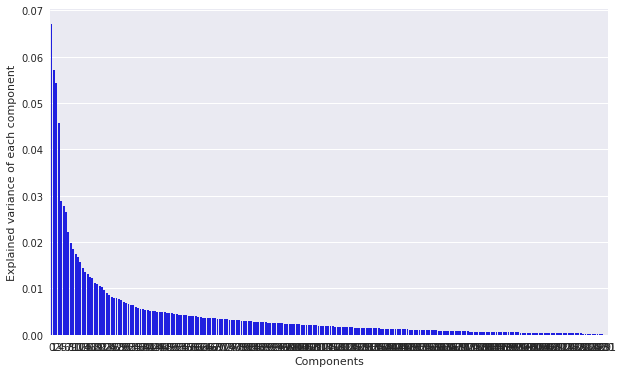

In [10]:
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x=np.arange(0,len(pca.explained_variance_ratio_)), y=pca.explained_variance_ratio_, color = 'blue')
ax.set(xlabel='Components', ylabel='Explained variance of each component')

Text(0,0.5,'cumulative explained variance')

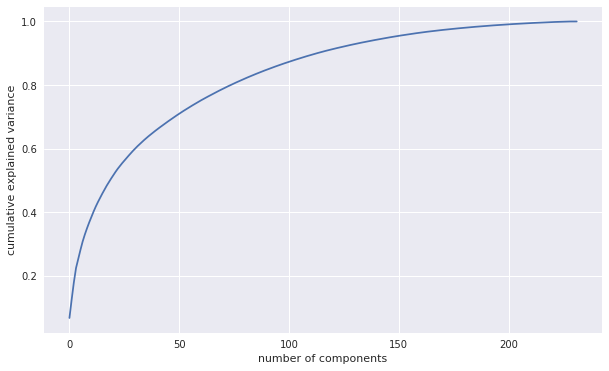

In [11]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [28]:
pca.explained_variance_ratio_.cumsum()[0:80]

array([ 0.08446572,  0.15176504,  0.19394215,  0.22697395,  0.25467901,
        0.28228044,  0.3071732 ,  0.32912257,  0.34902734,  0.36797148,
        0.38434616,  0.39957358,  0.41446177,  0.42794511,  0.4406132 ,
        0.45265827,  0.4642365 ,  0.4751217 ,  0.48536075,  0.49536682,
        0.50503058,  0.51429671,  0.5231542 ,  0.53152247,  0.53969483,
        0.54761064,  0.5551626 ,  0.56233981,  0.56949521,  0.57644792,
        0.58326942,  0.58984897,  0.59618362,  0.60246605,  0.60867866,
        0.61477158,  0.62081886,  0.62668541,  0.63251581,  0.63827363,
        0.64399571,  0.64967968,  0.65516898,  0.66047158,  0.66572742,
        0.67075742,  0.67572311,  0.68058898,  0.68530994,  0.69001117,
        0.69467249,  0.69924081,  0.70378088,  0.70819752,  0.71257861,
        0.71686738,  0.72106784,  0.72525646,  0.72935251,  0.73342537,
        0.73746042,  0.74141881,  0.7453627 ,  0.74926956,  0.75310313,
        0.75688921,  0.76066977,  0.76439674,  0.76811149,  0.77

Based on the charts, I can conclude that choosing 80 components will allow me to save most of the information from my data (80%) and significantly reduce number of dimensions. 

In [12]:
pca = PCA(n_components = 80)
azdias_pca = pca.fit_transform(azdias_fin)

In [ ]:
# applying pca to customers data
customers_pca = pca.transform(customers_fin)

As the main goal of the analysis is to understand which groups of German citizens are overrepresented and underrepresented in the customer base, I need to interpret which exactly demographic characteristics are caught by the principal components. Fot that, I will take the first 3 components and will explore which features correlate positviely and negatively with each of these components.

In [22]:
def map_pca_features(df, pca, component):
    """
    The function sorts features for the components based on the correlation values

    Arguments:
        df: pandas DataFrame
        pca: output of PCA function
        component: number of a component
        

    Returns:
        features names and correlation values sorted in a descending way
    """
    comp_weights = pd.DataFrame(pca.components_, columns=df.columns.values)
    return comp_weights.iloc[number_comp].sort_values(ascending=False)

In [45]:
map_pca_features(azdias_fin, pca, 0).head()

PLZ8_ANTG1        0.138950
LP_STATUS_GROB    0.127584
MOBI_REGIO        0.123153
PLZ8_GBZ          0.120669
KBA05_GBZ         0.120157
Name: 0, dtype: float64

In [46]:
map_pca_features(azdias_fin, pca, 0).tail()

KBA13_ALTERHALTER_30   -0.121358
KBA13_HALTER_30        -0.122371
HH_EINKOMMEN_SCORE     -0.123800
PLZ8_ANTG3             -0.130280
CAMEO_DEUG_2015        -0.142276
Name: 0, dtype: float64

Based on these features, I can say that the first component represents people with a quite high income living in a good neighborhood. They are rather houseowners or top earners (LP_STATUS_GROB), they possess relatively expensive cars (rather Gelendwagen or BMW than middle class class). Another important specific feature of these people is that they are not prone to mobility and are rather settled in the location where they live (MOBI_REGIO). The high correlation with the feature PLZ8_ANTG1 (number of 1-2 family houses in the PLZ8) tells us that these people live outside the city and possess a private house for 1 or 2 families. 

In [47]:
map_pca_features(azdias_fin, pca, 1).head()

EWDICHTE                       0.173626
ORTSGR_KLS9                    0.172953
KBA13_HERST_BMW_BENZ           0.160463
KBA13_SEG_OBEREMITTELKLASSE    0.144009
PLZ8_ANTG3                     0.142114
Name: 1, dtype: float64

In [48]:
map_pca_features(azdias_fin, pca, 1).tail()

KBA13_HALTER_20        -0.142821
KBA13_HALTER_50        -0.151983
KBA13_AUTOQUOTE        -0.153592
KBA13_HALTER_55        -0.157205
KBA13_ALTERHALTER_60   -0.173030
Name: 1, dtype: float64

The second component represents also people from upper-class, but, comparing to the first component, they live in big cities (I make this conclusion on the base of the negative correlation with PLZ8_ANTG1 and the high correlation with EWDICHTE -- density of inhabitants per square kilometer). Moreover, the negative correlation of this component with the feature INNENSTADT tells us that these people live rather in the centre of the big city. The high correlation with features KBA13_HERST_BMW_BENZ and KBA13_SEG_OBEREMITTELKLASSE tells us that the people possess quite expensive cars and rather relate to upper class.

In [49]:
map_pca_features(azdias_fin, pca, 2).head()

ALTERSKATEGORIE_GROB    0.234114
FINANZ_VORSORGER        0.207554
SEMIO_ERL               0.181393
SEMIO_LUST              0.154180
RETOURTYP_BK_S          0.142516
Name: 2, dtype: float64

In [50]:
map_pca_features(azdias_fin, pca, 2).tail()

SEMIO_PFLICHT           -0.226203
SEMIO_REL               -0.232986
FINANZ_UNAUFFAELLIGER   -0.239210
decade                  -0.245370
FINANZ_SPARER           -0.250196
Name: 2, dtype: float64

The third component represents senior people (ALTERSKATEGORIE_GROB), who have financial difficulties (FINANZ_VORSORGER), are not prone to visiting different events (SEMIO_ERL), not self-minded (SEMIO_LUST), rather dutyfull traditional minded (SEMIO_PFLICHT), religious (SEMIO_REL).

### Clustering

Before experimenting with different values for KMeans algorithm, I wanna explore how my data looks like. As I have many dimensions, I am choosing t-SNE algorithm for visualization. This algorithm allows to visualize high-dimensional data on a two-dimensional map. Here's the [article](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) based on which I applied t-SNE to my data.

In [13]:
# data is too big and I don't have enough computational power to apply t-SNE to the whole dataset, so I choose  
# randomly 50000 observations 
N = 50000
rndperm = np.random.permutation(pd.DataFrame(azdias_pca).shape[0])
pca_subset = pd.DataFrame(azdias_pca).loc[rndperm[:N],:].copy()

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 2.950s...
[t-SNE] Computed neighbors for 50000 samples in 935.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for 

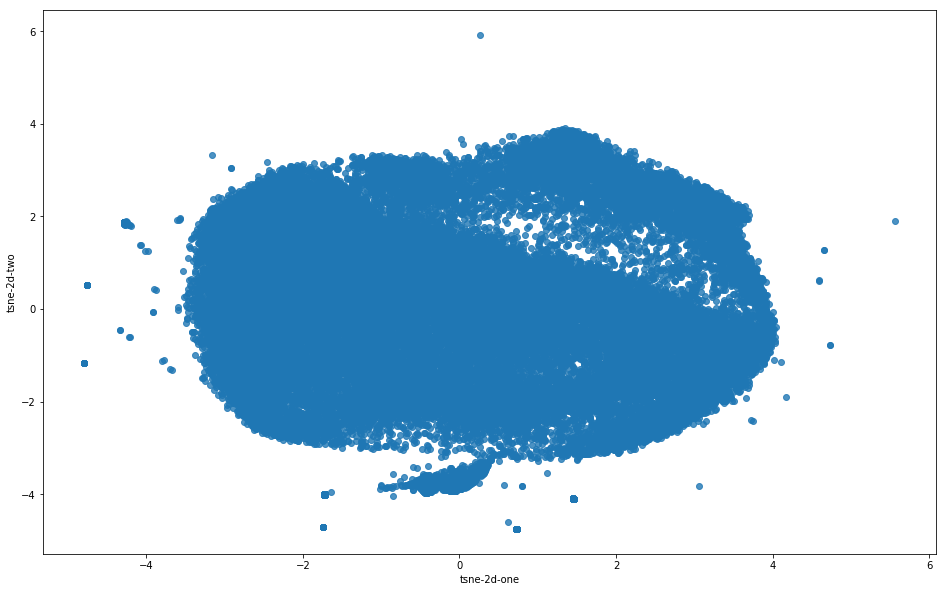

In [16]:
pca_subset['tsne-2d-one'] = tsne_results[:,0]
pca_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.regplot(
    x="tsne-2d-one", y="tsne-2d-two",
    fit_reg=False,
    data=pca_subset
)

Based on the chart, we can see that the data we have is not very clustered: we have one very big cluster, another cluster that is two or even three times smaller and one very small cluster.
In the next part of the notebook, I am calculating how measure representing distance between clusters and silhouette measure change for different number of clusters chosen for KMeans algorithm. Here's the useful [link](https://mmuratarat.github.io/2019-07-23/kmeans_from_scratch) that helped me to make this analysis. 

In [6]:
km_scores= []
km_silhouette = []

for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=0).fit(azdias_pca)
    preds = km.predict(azdias_pca)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(azdias_pca)))
    km_scores.append(-km.score(azdias_pca))
    
    silhouette = silhouette_score(azdias_pca,preds, sample_size = 20000)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

Score for number of cluster(s) 2: -155399975.39708403
Silhouette score for number of cluster(s) 2: 0.06979574308318694
Score for number of cluster(s) 3: -149136295.51802322
Silhouette score for number of cluster(s) 3: 0.07071813449952363
Score for number of cluster(s) 4: -144164945.73624
Silhouette score for number of cluster(s) 4: 0.06397749451426506
Score for number of cluster(s) 5: -139941720.80209365
Silhouette score for number of cluster(s) 5: -0.02383361191313636
Score for number of cluster(s) 6: -137352547.92597234
Silhouette score for number of cluster(s) 6: -0.02400183965280868
Score for number of cluster(s) 7: -135201479.9559229
Silhouette score for number of cluster(s) 7: -0.02844151888308345
Score for number of cluster(s) 8: -133400663.1762612
Silhouette score for number of cluster(s) 8: -0.020944059029377175
Score for number of cluster(s) 9: -131829309.68259615
Silhouette score for number of cluster(s) 9: -0.015028470327562915
Score for number of cluster(s) 10: -130503206.

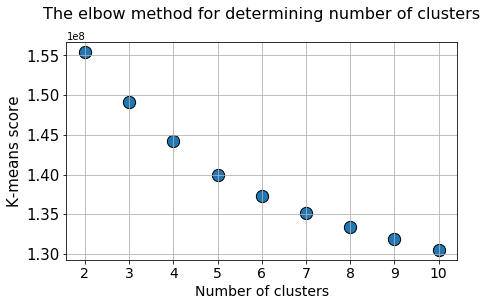

In [7]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,11)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,11)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

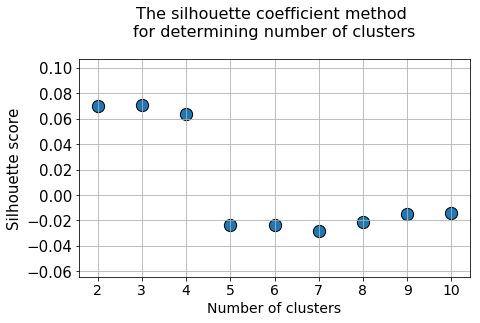

In [8]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,11)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,11)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Based on the charts, I can say that three clusters would be optimal number for the data I work with.

In [21]:
kmeans = KMeans(n_clusters = 3)
azdias_clusters = kmeans.fit(azdias_pca)
azdias_preds = azdias_clusters.predict(azdias_pca)

In [22]:
# clustering customers' data
customers_preds = kmeans.predict(customers_pca)

In the next chart, I am comparing how proportions of users realted to the identified clusters differ between Demogrpahics and Customers datasets.

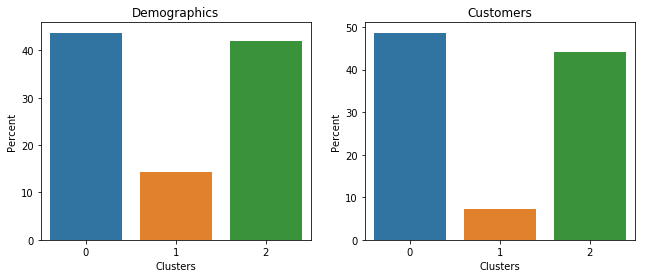

In [53]:
df_azdias = pd.DataFrame(azdias_preds, columns = ['cluster'])
df_azdias = df_azdias.groupby(['cluster'])['cluster'].count().reset_index(name = 'amnt')
df_azdias['perc'] = np.array(df_azdias['amnt']) / np.sum(df_azdias['amnt']) * 100

df_cust = pd.DataFrame(customers_preds, columns = ['cluster'])
df_cust = df_cust.groupby(['cluster'])['cluster'].count().reset_index(name = 'amnt')
df_cust['perc'] = np.array(df_cust['amnt']) / np.sum(df_cust['amnt']) * 100

fig, ax =plt.subplots(1,2)
sns.barplot(x="cluster", y="perc", data=df_azdias, ax=ax[0])
ax[0].set_title('Demographics')
ax[0].set_ylabel('Percent')
ax[0].set_xlabel('Clusters')
sns.barplot(x="cluster", y="perc", data=df_cust, ax=ax[1])
ax[1].set_title('Customers')
ax[1].set_ylabel('Percent')
ax[1].set_xlabel('Clusters')
plt.subplots_adjust(right = 1.5)

In [33]:
def describe_cluster(df, pca, cluster, num_components):
    """
    The function describes the clusters based on the principal components

    Arguments:
        df: pandas DataFrame
        pca: output of pca
        cluster: number of a cluster
        num_components: number of components that are used for the description

    Returns:
        main statistics returned by the function describe()
    """
    over_cl = list(df[df.cluster == cluster].index)
    return pd.DataFrame(df_pca).iloc[over_cl,0:num_components].describe()

In [34]:
describe_cluster(df_azdias, azdias_pca, 0, 3)

,0,1,2
count,389638.000000,389638.000000,389638.000000
mean,-2.073678,2.293626,-0.869743
std,2.640178,3.060553,2.875671
min,-13.854684,-7.577840,-8.219767
25%,-3.591051,0.280716,-3.147254
50%,-1.349120,1.347267,-1.646901
75%,-0.656504,4.132371,1.367259
max,8.033168,15.925068,10.389842


In [35]:
describe_cluster(df_azdias, azdias_pca, 1, 3)

,0,1,2
count,127312.000000,127312.000000,127312.000000
mean,-4.831331,-3.639679,2.299714
std,3.418688,3.235935,3.145289
min,-15.689891,-12.644590,-6.368807
25%,-7.443657,-6.064645,-0.244641
50%,-4.656204,-3.610157,2.410376
75%,-2.159803,-1.332731,4.644819
max,4.251669,6.424937,11.580173


In [36]:
describe_cluster(df_azdias, azdias_pca, 2, 3)

,0,1,2
count,374271.000000,374271.000000,374271.000000
mean,3.802245,-1.149726,0.123183
std,2.537057,3.367997,2.874897
min,-3.087176,-11.188386,-8.464736
25%,1.949924,-3.480802,-2.011806
50%,3.554075,-1.518872,0.365693
75%,5.390296,0.799301,2.288015
max,16.506995,14.794431,8.912665


The charts show that there are two clusters that are almost equally or even overrepresented in the customers' datasets: the first and the third clusters. The first cluster represnts upper-class citizens who live in highly urbanised localities. The third cluster stands for upper-class people, who live outside a city and are characterised by a low mobility level. At the same time, the second cluster is rather underrepresented in the customers' data. This cluster represents mostly  religious not self-minded senior people, who have financial difficulties and are not prone to visiting different cultural events. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [7]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# saving the RESPONSE variable into a separate object and removing it together with id (LNR) variable from the dataset
y = mailout_train['RESPONSE']
mailout_train = mailout_train.drop(['LNR', 'RESPONSE'], axis = 1)

### Cleaning and recoding

As the classification task does not require having all information on the varibales, I will be using all the variables regardless if they are described in the additional files. Therefore, I need to rewrite the function that replaces missing values with NaNs a bit. The new function does the same as the old one if a variable is in the Values dataset. If a variable is not in the dataset, the function recodes all string values into NaNs. It's quite rough way of recoding and I assume that not all missing values will be recoded, but it's the only thing I can do in this situation.

In [9]:
def replace_unknowns_for_classification(df):
    """
    The function applies 'identify_nans' for all columns that are described in the dataset 'values'. For other columns,
    the function transforms all string values into NaNs. 

    Arguments:
        df: Pandas DataFrame

    Returns:
        Pandas DataFrame with recoded values for all columns
    """
    df_copy = df.copy()
    for column in tqdm(df.columns):
        if column in list(values_na['Attribute']):
            df_copy[column] = identify_nans(column, df)
        else:
            df_copy[column] = df[column].apply(lambda x: np.nan if isinstance(x, str) else x)
    
    return df_copy

In [10]:
mailout_cleaned = replace_unknowns_for_classification(mailout_train)

  4%|▍         | 16/365 [00:02<02:09,  2.69it/s]/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 365/365 [03:52<00:00,  1.20it/s]


After recoding, I need to define the threshold for the missing values in columns and remove those columns that have a number of missing values that is higher than the chosen threshold. Finally, all the columns having more than 40% of missing values were removed.

(array([ 84.,   0.,   1., 174.,  62.,   1.,   2.,   1.,   5.,   3.,   4.,
          2.,   1.,   0.,   2.,   2.,   1.,   3.,   5.,  12.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

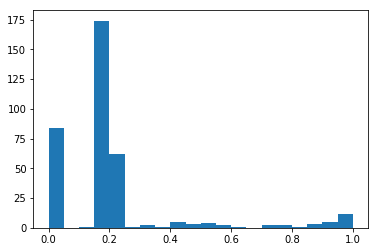

In [50]:
plt.hist((len(mailout_cleaned) - mailout_cleaned.count())/len(mailout_cleaned), bins = 20)

In [11]:
# the threshold of 0.4 was chosen for removing the columns
stay_mailout = mailout_cleaned.columns[(len(mailout_cleaned) - mailout_cleaned.count())/
                                             len(mailout_cleaned) <= 0.4]

In [12]:
mailout_cleaned = mailout_cleaned[stay_mailout]

In [13]:
# some minor changes were added to the function from the previous part of the analysis
def clean_recode_for_classification(df):
    """
    The function recodes the categorical variables and removes some redundant variables

    Arguments:
        df: pandas DataFrame

    Returns:
        Pandas DataFrame with recoded and removed variables
    """
    
    print('recoding missing values')
    
    df.loc[df['CAMEO_DEUG_2015'] == 'X', 'CAMEO_DEUG_2015'] = np.nan
    df.loc[df['ALTERSKATEGORIE_GROB'] == 9, 'ALTERSKATEGORIE_GROB'] = np.nan
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    print('making a dummy variable')
    
    west_ost = pd.get_dummies(df['OST_WEST_KZ'], dummy_na = True, drop_first = True)
    west_ost.columns = ['W', 'nans']
    west_ost.loc[west_ost['nans'] == 1, 'W'] = np.nan
    west_ost = west_ost.drop('nans', axis = 1)
    df = pd.concat([df, west_ost], axis = 1)
    
    print('making a decade and movement variables')
    
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda dec : 
                                                   40 if dec in [1,2]
                                                   else 50 if dec in [3,4]
                                                   else 60 if dec in np.arange(5,8)
                                                   else 70 if dec in [8,9]
                                                   else 80 if dec in np.arange(10,14)
                                                   else 90 if dec in [14,15]
                                                   else np.nan)
    
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda mov : 
                                                   0 if mov in [1,3,5,8,10,12,14]
                                                   else 1 if mov in [2,4,6,7,9,11,13,15]
                                                   else np.nan)
    
    print('removing redundant variables')
    
    df = df.drop(['OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)
    
    fein_columns = [col for col in df.columns if 'FEIN' in col]
    df = df.drop(fein_columns, axis = 1)
    
    return df

In [14]:
warnings.filterwarnings("ignore")
mailout_cleaned = clean_recode_for_classification(mailout_cleaned)

recoding missing values
making a dummy variable
making a decade and movement variables
removing redundant variables


Exploration of the dependent variable showed that it's highly imbalanced, and the number of clients who didn't response is much higher than those ones who responsed. That means that accuracy wouldn't be a good measure for estimationg the quality of a model; I take AUC instead of it. 

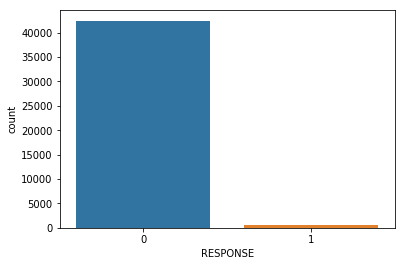

In [20]:
g = sns.countplot(y)
plt.show()

In [15]:
# imputing NaNs and scaling variables
impute = SimpleImputer(missing_values=np.nan)
scaler = StandardScaler() 

In [16]:
mailout_imputed = pd.DataFrame(impute.fit_transform(mailout_cleaned))
mailout_scaled = pd.DataFrame(scaler.fit_transform(mailout_imputed))

### Classification

After cleaning and preparing data, I can move to the classification.

In [18]:
def mailout_classify(X, y, classifier, params, imbalance_fixed = False):
    """
    The function uses GridSearchCV to find the best paprmeters 

    Arguments:
        X: Pandas DataFrame with features
        y: Pandas Series with outcomes
        params: dictitonary with parameters for a model
        imbalance_fixed: if True, applies oversampling to data

    Returns:
        best estimator returned by GridSearchCV
    """
    
    if imbalance_fixed == True:
        ros = SMOTE(random_state=17)
        X, y = ros.fit_resample(X, y)
    
    grid_obj = GridSearchCV(classifier, params, scoring='roc_auc', cv=5) 
    grid_fit = grid_obj.fit(X, y)    
    
    print('Best score: ', str(grid_fit.best_score_))
    
    return grid_fit.best_estimator_

First, I identify the classification algorithm that works better without tuning parameters.

In [65]:
random_forest = RandomForestClassifier()
rf_res = mailout_classify(mailout_scaled, y, random_forest, {})

Best score:  0.6022082103717417


In [66]:
log_reg = LogisticRegression()
lr_res = mailout_classify(mailout_scaled, y, log_reg, {})

Best score:  0.6651317907079666


In [67]:
adaboost = AdaBoostClassifier()
adaboost_res = mailout_classify(mailout_scaled, y, adaboost, {})

Best score:  0.7323607705044951


In [68]:
gradient_boost = GradientBoostingClassifier()
gradient_boost_res = mailout_classify(mailout_scaled, y, gradient_boost, {})

Best score:  0.7537311342469406


In [69]:
lgbm = LGBMClassifier()
lgbm_res = mailout_classify(mailout_scaled, y, lgbm, {})

Best score:  0.7031913101928585


GradientBoostingClassifier gave the best result, so I take it for further classification.

In [33]:
# setting the parameters for Gradient Boosting
gradient_boost = GradientBoostingClassifier()
gb_parameters = {
    "n_estimators":[200, 300, 400],
    "learning_rate":[0.001, 0.005, 0.01, 0.1]
}

In [34]:
gradient_boost_best = mailout_classify(mailout_scaled, y, gradient_boost, gb_parameters)

Best score:  0.7619370186326162


In [35]:
gradient_boost_best

GradientBoostingClassifier(learning_rate=0.01, n_estimators=300)

Another classifier will have the best parameters identified by GridSearchCV, but the data will be oversampled. It's one of the methods to avoid problems related to imbalanced datasets.

In [19]:
gb_best_params = {
    "n_estimators":[300],
    "learning_rate":[0.01]
}

In [22]:
gradient_boost_best_balanced = mailout_classify(mailout_scaled, y, gradient_boost, gb_best_params, 
                                                imbalance_fixed = True)

Best score:  0.9785621854942459


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [23]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [24]:
lnr = mailout_test['LNR']

In [25]:
mailout_test = mailout_test.drop(['LNR'], axis = 1)

In [29]:
mailout_test.shape

(42833, 365)

In [26]:
mailout_test_cleaned = replace_unknowns_for_classification(mailout_test)

100%|██████████| 365/365 [03:46<00:00,  1.22it/s]


In [27]:
stay_mailout_test = mailout_test_cleaned.columns[(len(mailout_test_cleaned) - mailout_test_cleaned.count())/
                                             len(mailout_test_cleaned) <= 0.4]

In [28]:
mailout_test_cleaned = mailout_test_cleaned[stay_mailout_test]

In [35]:
mailout_test_cleaned.shape

(42833, 325)

In [29]:
mailout_test_cleaned = clean_recode_for_classification(mailout_test_cleaned)

recoding missing values
making a dummy variable
making a decade and movement variables
removing redundant variables


In [30]:
mailout_test_imputed = pd.DataFrame(impute.transform(mailout_test_cleaned))
mailout_test_scaled = pd.DataFrame(scaler.transform(mailout_test_imputed))

In [39]:
# applying gradient boosting without oversampling
preds = gradient_boost_best.predict_proba(mailout_test_scaled)
preds

array([[0.96749548, 0.03250452],
       [0.9717565 , 0.0282435 ],
       [0.995392  , 0.004608  ],
       ...,
       [0.97150232, 0.02849768],
       [0.98029384, 0.01970616],
       [0.98253684, 0.01746316]])

In [222]:
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':preds[:,1]})
result.to_csv(path_or_buf='./result_gb_best.csv', index=False)

In [ ]:
# applying gradient boosting with oversampling
preds_balanced = gradient_boost_best_balanced.predict_proba(mailout_test_scaled)

In [46]:
result_balanced = pd.DataFrame({'LNR':lnr, 'RESPONSE':preds_balanced[:,1]})
result_balanced.to_csv(path_or_buf='./result_gb_balanced.csv', index=False)